## Drone Detection

In [45]:
# essential imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# import YOLO model from ultralytics package
from ultralytics import YOLO

In [15]:
# load pretrained YOLOv8 model
model = YOLO("yolov8n.pt")  # n for nano, s for small, m for medium, l for large, x for extra large


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /Users/nickmorrison/Desktop/drone-tracker/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 121.8ms
Speed: 2.5ms preprocess, 121.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


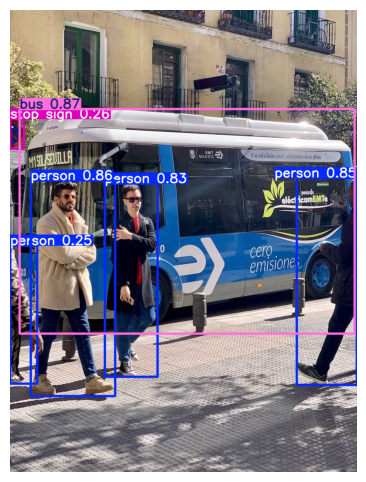

In [13]:
# Run on a sample image
results = model("https://ultralytics.com/images/bus.jpg", show=True)

# 3. Get the plotted image with bounding boxes
annotated_frame = results[0].plot()  # numpy array (BGR format)

# 4. Convert BGR → RGB for matplotlib
annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

# 5. Show with matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(annotated_frame)
plt.axis("off")
plt.show()

#### Try on drone video

In [52]:
# source video path
data_path = './data/drone-tracking-datasets/'
video_path = os.path.join(data_path, 'dataset1/cam0.mp4')

# run detection on video
results = model.predict(
    source=video_path, 
    #tracker="sort.yaml",  # or 'bytetrack.yaml', 'strongsort.yaml'
    #show=True, # display live output
    save=True,  # save output video to runs/detect/
    stream=True  # return a generator that yields results for each frame, doesn't store whole video in memory
)

KeyboardInterrupt: 

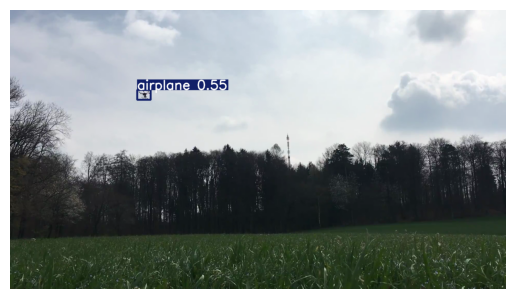

In [53]:
# display results frame by frame inline, by iterating through the generator
# otherwise can open in external window with show=True above

for result in results:
    annotated_frame = result.plot()
    annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

    plt.imshow(annotated_frame)
    plt.axis("off")
    clear_output(wait=True)  # clear previous cell output
    display(plt.gcf())


video 1/1 (frame 1/5334) /Users/nickmorrison/Desktop/drone-tracker/data/drone-tracking-datasets/dataset1/cam0.mp4: 384x640 1 kite, 55.4ms


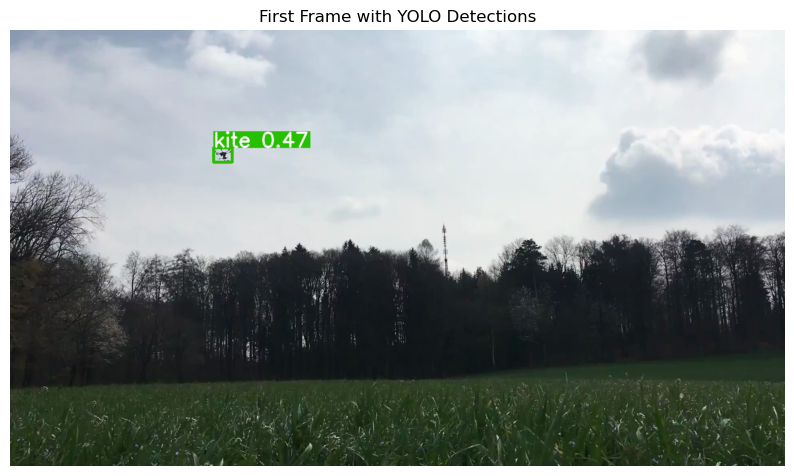

In [51]:
# Grab first frame only
first_result = next(iter(results))

# Plot with bounding boxes
annotated_frame = first_result.plot()  # numpy array, BGR format
annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

# Show with matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(annotated_frame)
plt.axis("off")
plt.title("First Frame with YOLO Detections")
plt.show()